# Google Trends analytics using Python
- Here we will be analyzing the Google search trends on the queries of our intered {You will get a chance to provide input}.

In [ ]:
#!pip install pytrends
#!pip install pycountry-convert # for mapplot
#!pip install geopy
#!pip install folium

***Start with importing libraries.***
---
*Probably need to run "pip install pytrends"*

In [679]:
# import necessary libaries
import pandas as pd
import numpy as np

from pytrends.request import TrendReq

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import load_dataset

import warnings
warnings.filterwarnings("ignore")

import re
from textblob import TextBlob
from wordcloud import WordCloud

from spacy.lang.en.stop_words import STOP_WORDS as en_stop #stopwords in English
from spacy.lang.da.stop_words import STOP_WORDS as da_stop #stopwords in Danish
final_stopwords= en_stop.union(da_stop)

# Connect to google and Build Payload
> The build_payload method from Pytrends is used to build a list of keywords that want to search in Google Trends. Can also specify the timeframe to gather data and the category to query the data from.
---
*kw_list:* list of the target search terms 

*cat:* Category to narrow result fx. Art, Entertainment.[link for category](https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories)

*timeframe:* Date to start from fx. Defaults to last 5yrs is 'today 5-y' or Everything is 'all'

*geo:* Location of interest represent by two letter country abbreviation fx. United States is 'US' or Defaults to World

*gprop:* What Google property to filter to fx. "image" or "news" default to web searches

In [680]:
# Function for connecting google and build playload
def pytrends_func(kw_list, timeframe):
  # Configuring connection wich receives two important parameters; hl (hosting language) & tz (timezone).
  trends = TrendReq(hl='en-US', tz= 360, timeout=(10,25))
  
  # Update playload
  trends.build_payload(kw_list=kw_list, cat=0, timeframe=timeframe, geo= '', gprop='') #timeframe='today 5-y'
  
  # return the trends object
  return trends

kw_list = ["Healthy diet", "Healthy food"] 
trends= pytrends_func(kw_list, 'today 12-m')
trends

# What kind of data want to pull? possible methods are:
- ***Interest Over Time:*** returns historical, indexed data for when the keyword was searched
- Historical Hourly Interest:  returns historical, indexed, hourly data for when the keyword was searched
- ***Interest by Region:*** returns data for where the keyword is most searched
- Related Topics: returns data for the related keywords to a provided keyword
- Related Queries: returns data for the related keywords to a provided keyword
- ***Trending Searches:*** returns data for latest trending searches
- Top Charts: returns the data for a given topic
- Suggestions: returns a list of additional suggested keywords that can be used to refine a trend search.

In [681]:
# Function to Disply in the figure
def display_lineplot(df, x, kw_list, title, x_label, y_label):
    """ The function will take x & value including title, x_label & y_label then display the figure"""
    fig, ax = plt.subplots(figsize= (10, 5))  # Create a figure containing a single axes. Alt-figsize= (10, 5)#, layout='constrained'
    
    # loop over columns to dorw line-plot and add to the figure
    for col in kw_list:
      ax.plot(df[x], df[col], label = col)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend()  # Add a legend.
    #ax.grid(axis= "y")
    plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)# Add x, y gridlines
    plt.show()

def display_barplot(df, x_col, kw_list, title):
  fig, ax = plt.subplots(figsize= (10, 5))

  # loop over columns to dorw line-plot and add to the figure
  for col in kw_list:
    ax.bar(df[x_col], df[col], label= col)#, color ='blue', width = 0.4

  plt.title(title, fontsize=12)
  plt.xticks(rotation=45)
  plt.xlabel(x_col)
  plt.ylabel("Values")
  #plt.text(0.0, 0.0, 'CopyRight Mukti. R. Chapagain, 2022', fontsize = 10, color ='grey', ha ='right', va ='bottom', alpha = 0.7) # Add Text watermark  
  #plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)# Add x, y gridlines
  ax.grid(axis= "y")
  plt.show()

***Interest Over Time***

,date,Healthy diet,Healthy food
46,2022-08-21,23,69
47,2022-08-28,26,77
48,2022-09-04,25,82
49,2022-09-11,26,87
50,2022-09-18,27,85


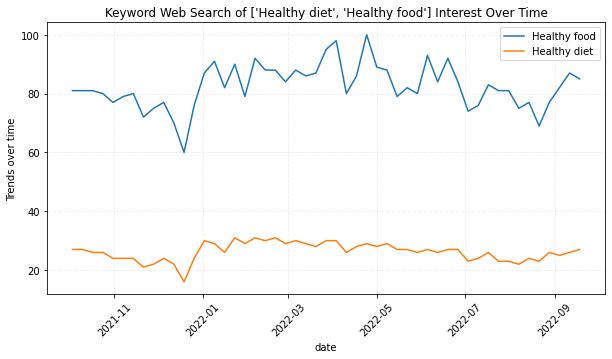

In [682]:
# function to extract interest over time
def gt_trends_over_time():
  # Interest Over Time
  data_over_time= trends.interest_over_time().drop(columns='isPartial')
  data_over_time = data_over_time.reset_index(drop=False)
  return data_over_time

display(gt_trends_over_time().tail())
data_over_time= gt_trends_over_time()

# Disply figure as lineplot
display_lineplot(data_over_time, "date", ["Healthy food", "Healthy diet"], title= f'Keyword Web Search of {kw_list} Interest Over Time', x_label= "date", y_label="Trends over time")

**Historical Hourly Interest**

,date,Healthy diet,Healthy food
0,2022-09-01 00:00:00,10,70
2,2022-09-01 02:00:00,24,64
3,2022-09-01 03:00:00,16,26
4,2022-09-01 04:00:00,8,54
5,2022-09-01 05:00:00,32,53


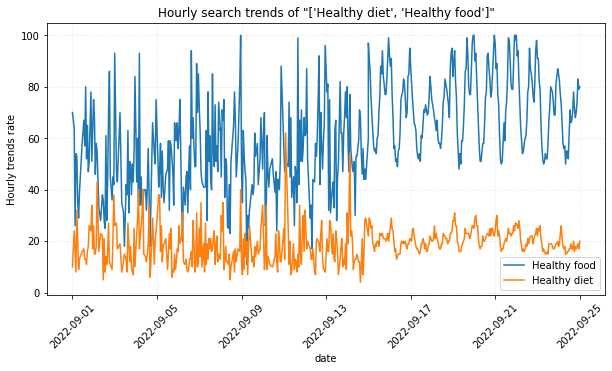

In [683]:
# Function for Historical hourly interest
def gt_hh_trends():
  # Historical Hourly Interest (The hourly interest of the keyword)
  hourly_trends= trends.get_historical_interest(kw_list, year_start=2022, month_start=9, day_start=1, hour_start=0, year_end=2022, month_end=9, day_end=25, hour_end=0, cat=0, sleep=0)
  hourly_trends = hourly_trends.reset_index().drop(columns='isPartial')
  return hourly_trends[hourly_trends[kw_list[0]]> 0]

data_hourly_trends=gt_hh_trends()
display(data_hourly_trends.head())

# Disply figure as lineplot
display_lineplot(data_hourly_trends, "date", ["Healthy food", "Healthy diet"], title= f'Hourly search trends of "{kw_list}"', x_label= "date", y_label="Hourly trends rate")


**Interest by Region(Search by geographical region)**

To show you which countries search the keyword on a scale of 0 to 100, where 100 represents a country with the most search

*The resolution value is dependent on the geo parameter of the common configuration:*

*Use resolution='COUNTRY' for geo='World'*

*Use resolution='REGION' for geo='US', Two letter country abbreviation. for example*

*gprop= What Google property to filter to.Can be `images, news, youtube or froogle`*

,geoName,Healthy diet,Healthy food
0,Ghana,36,64
1,Kenya,34,66
2,Pakistan,32,68
3,United Kingdom,31,69
4,South Africa,30,70


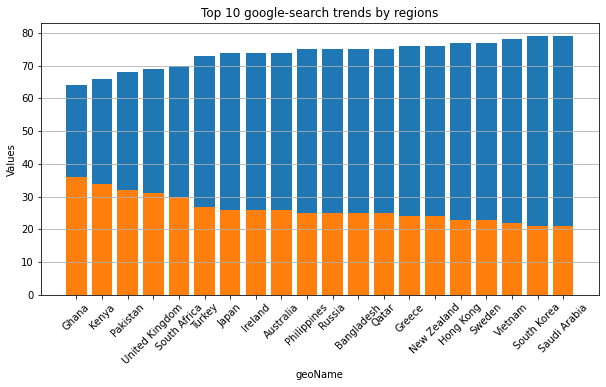

In [723]:
# Function for interest by region
def gt_trends_byregion():
  #trends= pytrends_func(["Healthy diet"], 'today 12-m', geo='', gprop='')
  # resolution can be either CITY, COUNTRY or REGION
  trends_by_region= trends.interest_by_region(resolution= 'COUNTRY', inc_low_vol=False, inc_geo_code=False)
  
  # Make a look with kw_list

  trends_by_region = trends_by_region.sort_values(by=kw_list[0], ascending=False).reset_index()
  return trends_by_region

df_byregion= gt_trends_byregion()
display(df_byregion.head())

display_barplot(df_byregion.iloc[:20,:], "geoName", ["Healthy food", "Healthy diet"], "Top 10 google-search trends by regions")

In [742]:
df_byregion["Healthy_diet%"]= df_byregion["Healthy diet"].apply(lambda x: x*0.01)
df_byregion["Healthy_food%"]= df_byregion["Healthy food"].apply(lambda x: x*0.01)
df_byregion.head()

,geoName,Healthy diet,Healthy food,Healthy_diet%,Healthy_food%
0,Ghana,36,64,0.36,0.64
1,Kenya,34,66,0.34,0.66
2,Pakistan,32,68,0.32,0.68
3,United Kingdom,31,69,0.31,0.69
4,South Africa,30,70,0.30,0.70


In [782]:
# for map-plot
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

# function yo display in map
def display_mapplot(df_byregion, col):
  # Data with two columns
  df_byregion["Healthy_diet%"]= df_byregion["Healthy diet"].apply(lambda x: x*0.01)
  df_byregion["Healthy_food%"]= df_byregion["Healthy food"].apply(lambda x: x*0.01)

  # Conversion to Alpha 2 codes and Continents
  #function to convert to alpah2 country codes and continents
  def get_continent(col):
    try:
      cn_a2_code =  country_name_to_country_alpha2(col)
    except:
      cn_a2_code = 'Unknown' 
    try:
      cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
      cn_continent = 'Unknown'
    return (cn_a2_code, cn_continent)

  #Apply function to get Alpha 2 codes and Continents
  df_byregion["codes"]= df_byregion["geoName"].apply(get_continent)
  df_byregion["Country"]= df_byregion["codes"].apply(lambda x: x[0])
  df_byregion["Continent"]= df_byregion["codes"].apply(lambda x: x[1])

  # Get longitude and latitude
  #function to get longitude and latitude data from country name
  from geopy.geocoders import Nominatim
  geolocator = Nominatim()
  def geolocate(country):
    try:
      # Geolocate the center of the country
      loc = geolocator.geocode(country)
      # And return latitude and longitude
      return (loc.latitude, loc.longitude)
    except:
      # Return missing value
      return np.nan

  # Apply function to get Alpha 2 codes and Continents
  df_byregion["Geolocate"]= df_byregion["Country"].apply(geolocate)
  df_byregion["Latitude"]= df_byregion["Geolocate"].apply(lambda x: x[0])
  df_byregion["Longitude"]= df_byregion["Geolocate"].apply(lambda x: x[1])
  
  ## Create a world map
  # Create a world map to show distributions of users 
  import folium
  from folium.plugins import MarkerCluster

  #empty map
  world_map= folium.Map(tiles="cartodbpositron")
  marker_cluster = MarkerCluster().add_to(world_map)

  #for each coordinate, create circlemarker of user percent
  for i in range(len(df_byregion)):
    lat = df_byregion.iloc[i]['Latitude']
    long = df_byregion.iloc[i]['Longitude']
    radius=5
    popup_text = """Country : {}<br> %of Users : {}<br>"""
    popup_text = popup_text.format(df_byregion.iloc[i]['Country'], df_byregion.iloc[i]['User_Percent'])

    folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
  #show the map
  world_map

  return df_byregion

display_mapplot(df_byregion.iloc[:20,:], "geoName")

,geoName,Healthy diet,Healthy food,Healthy_diet%,Healthy_food%,codes,Country,Continent,Geolocate
0,Ghana,36,64,0.36,0.64,"(GH, AF)",GH,AF,"(8.0300284, -1.0800271)"
1,Kenya,34,66,0.34,0.66,"(KE, AF)",KE,AF,"(1.4419683, 38.4313975)"
2,Pakistan,32,68,0.32,0.68,"(PK, AS)",PK,AS,"(30.3308401, 71.247499)"
3,United Kingdom,31,69,0.31,0.69,"(GB, EU)",GB,EU,"(54.7023545, -3.2765753)"
4,South Africa,30,70,0.30,0.70,"(ZA, AF)",ZA,AF,"(-28.8166236, 24.991639)"
5,Turkey,27,73,0.27,0.73,"(TR, AS)",TR,AS,"(38.9597594, 34.9249653)"
6,Japan,26,74,0.26,0.74,"(JP, AS)",JP,AS,"(36.5748441, 139.2394179)"
7,Ireland,26,74,0.26,0.74,"(IE, EU)",IE,EU,"(52.865196, -7.9794599)"
8,Australia,26,74,0.26,0.74,"(AU, OC)",AU,OC,"(-24.7761086, 134.755)"
9,Philippines,25,75,0.25,0.75,"(PH, AS)",PH,AS,"(12.7503486, 122.7312101)"


**Related Queries**

In [694]:
#function for releted queries
def gt_related_queries():
  # Related Queries (keywords that are closely tied to a primary keyword of the choice)
  related_queries= trends.related_queries()
  df= pd.DataFrame()# Empty dataframe
  for kw in kw_list:
    df1= related_queries[kw]['top']
    df= pd.concat([df, df1], axis = 1)
  return df

releted_queries=gt_related_queries()
releted_queries.head()

,query,value,query,value
0,healthy food,100,food near me,100
1,diet food,100,healthy food near me,99
2,healthy food diet,99,what is healthy food,62
3,what is healthy diet,96,eat healthy,51
4,what is diet,95,eat healthy food,51


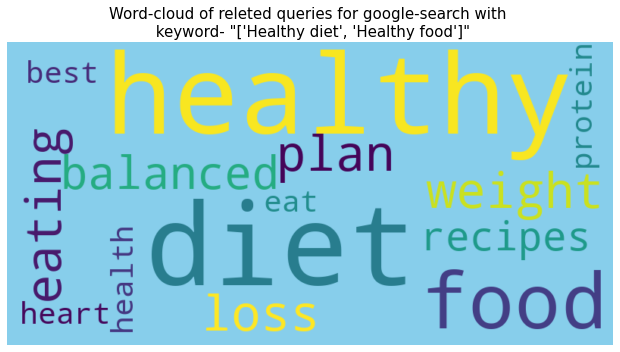

In [706]:
def cleanText(text):
      text= re.sub(r'@[A-Za-z0-9]+', '',text) # Removed @mentions
      text= re.sub(r'#', '',text) # the '#' symbol
      text= re.sub(r':', '',text) # the ':' symbol
      text= re.sub(r'RT[\s]+', '',text) # Removed RT
      text= re.sub(r'https?:\/\/\s+', '',text) # Removed the hyper link
      return text
      
#Function for word-cloud
def wordcloud_plot(releted_queries, title):
  #lets clean the xext first
  releted_queries["query"]= releted_queries["query"].apply(cleanText)
  # Create stopword list
  final_stopwords.update(['https', 'er', 'og', 't', 'co', 'A', 't','The'])
  
  plt.figure(figsize=(10,5))
  allWords= ' '.join( [twts for twts in releted_queries["query"]] )
  wordcloud = WordCloud(stopwords=final_stopwords, max_words=300, width= 800, height=400, random_state=21, max_font_size= 150, background_color="skyblue").generate(allWords)
  
  plt.imshow(wordcloud, interpolation = "bilinear")
  plt.title(title, fontsize=15)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

wordcloud_plot(releted_queries.iloc[:, 0:2], f'Word-cloud of releted queries for google-search with \n keyword- "{kw_list}"')

**Trending topics of the year**

In [ ]:
# Function for topics of the year
def gt_topics_ofthe_year():
  trends= gt_playload()
  df= pd.DataFrame()# Empty dataframe
  # loop over the year to extract data for each year and put in dataframe as columns
  for year in range(2004, 2022):
      trending = trends.top_charts(year, hl= "en-US", tz=300, geo= "GLOBAL")
      df[year]= trending.title     
  return df.iloc[:, :9].head(5)

gt_topics_ofthe_year()

**Trending Searches (latest trending searches) in a Specific Country**
---
*It highlight stories that are trending across Google surfaces within the last 24 hours and are updated in real-time*

-The` "pn"` argument specifies the geographical location, the name of country in small letter.

In [ ]:
# Functing to get latest trending searches
def latest_trending_searches(country_list):
  df_trends= pd.DataFrame()# Empty dataframe
  for country in country_list:
    df_trends[country] = trends.trending_searches(pn=country)
  return df_trends.head(5)

latest_trending_searches(["denmark", "united_states", "sweden", "india"])

#Realtime Search Trends
**- Country code in CAPITAL**

- *Realtime Search Trends highlight stories that are trending across Google surfaces within the last 24 hours, and are updated in realtime.*

In [ ]:
# Function for Realtime Search Trends
def realtime_search_trends(country_dict):
  trends= gt_playload()
  df_trends= pd.DataFrame()# Empty dataframe

  for country_key, country_val in country_dict.items():
    df_trends[country_val] = trends.realtime_trending_searches(pn=country_key)["title"]
    
  return df_trends.head(10)

country_dict= {"US":"United_State", "RU":"Russia", "SE":"Sweden", "DE":"Germeny"}
realtime_search_trends(country_dict)
#trends.realtime_trending_searches(pn="US")["title"]